# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
#import os
#os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
!python -m pip install -r requirements.txt

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
## YOUR CODE HERE ##

# Create training set and define training dataloader
## YOUR CODE HERE ##

# Create test set and define test dataloader
## YOUR CODE HERE ##
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

 The preprocessing steps I chose are common and effective for the MNIST dataset. Let me explain it:

 1. `transforms.ToTensor()`:
   This transform converts the PIL Image or numpy.ndarray to a torch.FloatTensor. It's necessary because PyTorch models expect input data to be in tensor format. This also scales the image pixel values from 0-255 to 0-1, which is a helpful normalization step.

 2. `transforms.Normalize((0.5,), (0.5,))`:
   This normalizes the tensor image with a mean of 0.5 and standard deviation of 0.5. Here's why this is beneficial:

   - It centers the data around zero, which can help with training stability.
   - It scales the data to a similar range, which can help the model learn more effectively.
   - For MNIST, which has grayscale images, we use a single value for mean and std dev.
   - The values (0.5, 0.5) map the 0-1 pixel values to the range [-1, 1], which is a common practice.

 These transforms are particularly suitable for MNIST because:

 1. MNIST images are grayscale, so we don't need more complex color normalization.
 2. The images are already size-normalized and centered, so we don't need additional resizing or centering transforms.
 3. These simple transforms are computationally efficient, which is good for a large dataset like MNIST.

 If you wanted to expand on this preprocessing, you could consider:

 - Data augmentation techniques like small rotations or shifts, which could help the model generalize better.
 - Applying additional transforms like `transforms.RandomAffine` for slight distortions, which could make the model more robust to variations in handwriting.

 However, the current preprocessing is a solid starting point for training on MNIST. It prepares the data in a format suitable for neural networks while applying basic normalization that can aid in faster convergence during training.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


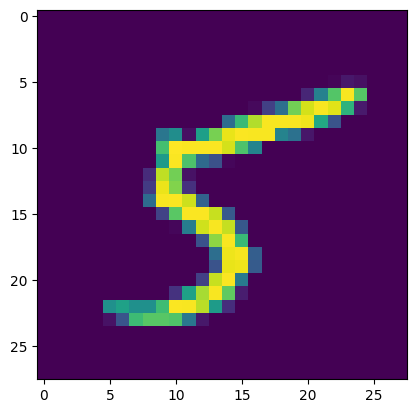

6


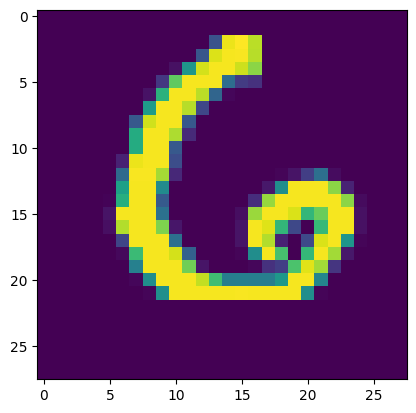

8


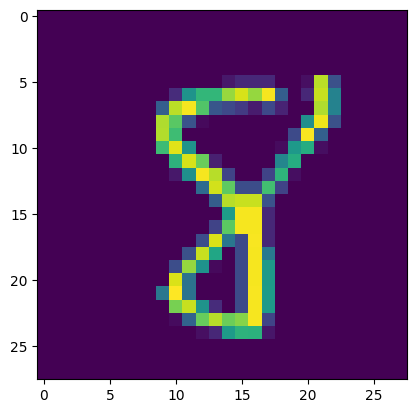

7


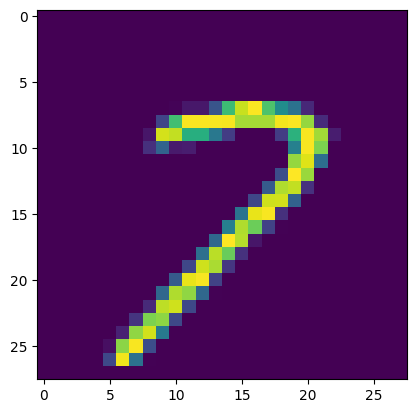

1


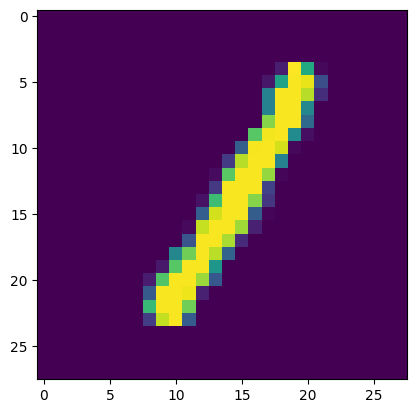

In [6]:
show5(train_loader)

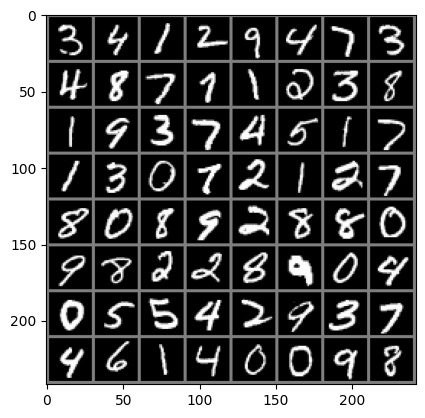

Original shape: torch.Size([1, 28, 28])
Transformed shape: torch.Size([784])


In [7]:
# Explore data
## YOUR CODE HERE ##
# Function to visualize data
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Visualize some samples
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images.view(-1, 1, 28, 28)))

# Explore the size and shape of the data
print(f"Original shape: {images[0].shape}")
print(f"Transformed shape: {images.view(-1, 28 * 28)[0].shape}")

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28) #Flatenning the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Instantiate the network, define the criterion and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
## YOUR CODE HERE ##

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

[1, 200] loss: 0.8311736393719912
[1, 400] loss: 0.360723322480917
[1, 600] loss: 0.2881937312707305
[1, 800] loss: 0.24157555043697357
[2, 200] loss: 0.17929927518591285
[2, 400] loss: 0.16822851627133786
[2, 600] loss: 0.15570280116982757
[2, 800] loss: 0.13408617230132222
[3, 200] loss: 0.10923476893454791
[3, 400] loss: 0.11014536581002175
[3, 600] loss: 0.10480456768535078
[3, 800] loss: 0.11049808280076831
[4, 200] loss: 0.07877705358201638
[4, 400] loss: 0.08556902072392404
[4, 600] loss: 0.09138445115415379
[4, 800] loss: 0.08161718207877129
[5, 200] loss: 0.06581348005915061
[5, 400] loss: 0.06501606355886906
[5, 600] loss: 0.07005440736247692
[5, 800] loss: 0.06976736038457602
[6, 200] loss: 0.05381086234701797
[6, 400] loss: 0.058406797216739505
[6, 600] loss: 0.057125479474198076
[6, 800] loss: 0.05698992505203933
[7, 200] loss: 0.04710966765997
[7, 400] loss: 0.04369584095373284
[7, 600] loss: 0.043981260563014074
[7, 800] loss: 0.04897512410767377
[8, 200] loss: 0.0376804

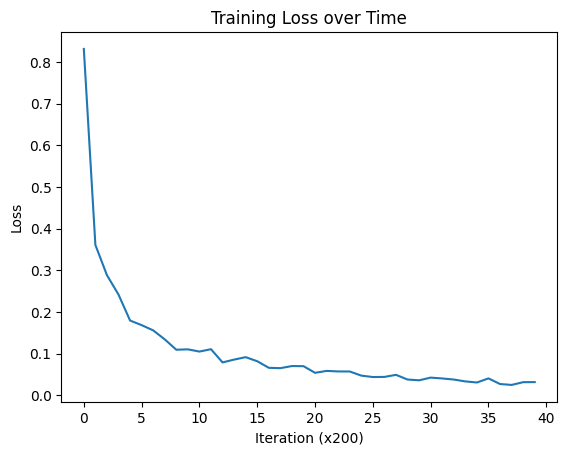

In [10]:
## YOUR CODE HERE ##
# Training loop
epochs = 10
losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            losses.append(running_loss / 200)
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200}")
            running_loss = 0.0

print("Finished Training")

# Plot the training loss
plt.plot(losses)
plt.xlabel('Iteration (x200)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')

# Save the plot as an image file
plt.savefig('training_loss.png')

# Convert Matplotlib figure to PIL Image
fig = plt.gcf()
fig.canvas.draw()
image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Display the image
#image.show()
plt.show()


Plot the training loss (and validation loss/accuracy, if recorded).

In [11]:
## YOUR CODE HERE ##

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
## YOUR CODE HERE ##
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct / total} %")


Accuracy of the network on the 10000 test images: 97.95 %


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

[1, 200] loss: 0.5690910157188773
[1, 400] loss: 0.15634106835350395
[1, 600] loss: 0.1194486284814775
[1, 800] loss: 0.1010963133443147
[2, 200] loss: 0.07210332232294604
[2, 400] loss: 0.06544305474613793
[2, 600] loss: 0.062380355503410104
[2, 800] loss: 0.06319049566518516
[3, 200] loss: 0.04602778449421749
[3, 400] loss: 0.04855963592650369
[3, 600] loss: 0.051671462141675874
[3, 800] loss: 0.04712067929562181
[4, 200] loss: 0.03231711829721462
[4, 400] loss: 0.036384663803619335
[4, 600] loss: 0.03411606173729524
[4, 800] loss: 0.04006158672622405
[5, 200] loss: 0.024707581649854548
[5, 400] loss: 0.03264087885414483
[5, 600] loss: 0.035687548354035245
[5, 800] loss: 0.027828547914978116
[6, 200] loss: 0.019253678714449052
[6, 400] loss: 0.026447413207788487
[6, 600] loss: 0.025645883837132715
[6, 800] loss: 0.025196529719687534
[7, 200] loss: 0.01924128945625853
[7, 400] loss: 0.02159618192927155
[7, 600] loss: 0.020132295920557226
[7, 800] loss: 0.021603620296082225
[8, 200] lo

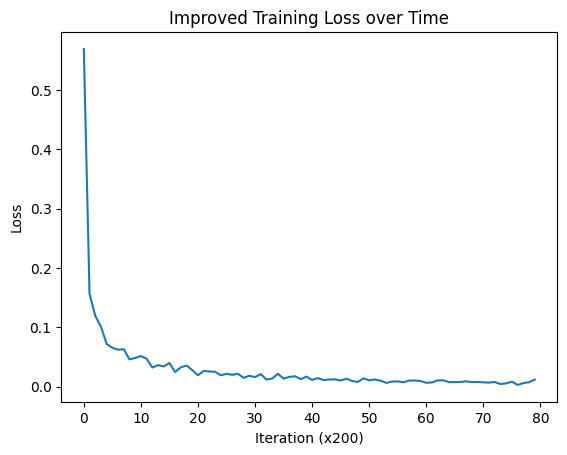

In [13]:
## YOUR CODE HERE ##
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the network, define the criterion and optimizer
improved_net = ImprovedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_net.parameters(), lr=0.001)

# Training the improved network
epochs = 20
improved_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape to match the input shape expected by conv layers
        optimizer.zero_grad()
        outputs = improved_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            improved_losses.append(running_loss / 200)
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200}")
            running_loss = 0.0

print("Finished Training Improved Network")

# Plot the training loss
plt.plot(improved_losses)
plt.xlabel('Iteration (x200)')
plt.ylabel('Loss')
plt.title('Improved Training Loss over Time')

# Save the plot as an image file
plt.savefig('training_loss_improved.png')

# Convert Matplotlib figure to PIL Image
fig = plt.gcf()
fig.canvas.draw()
image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# Display the image
#image.show()
plt.show()

In [14]:

# Evaluate the improved model
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.view(-1, 1, 28, 28)  # Reshape to match the input shape expected by conv layers
        outputs = improved_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the improved network on the 10000 test images: {100 * correct / total} %")

Accuracy of the improved network on the 10000 test images: 99.05 %


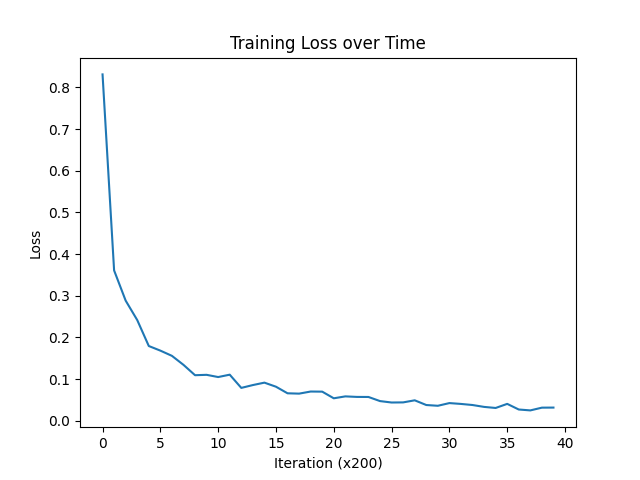

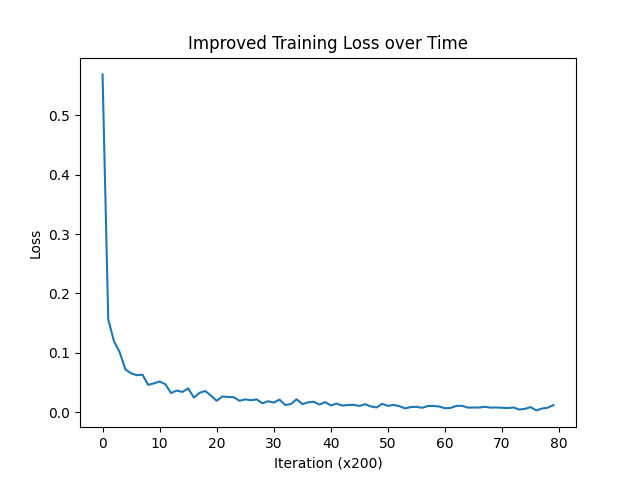

In [18]:
image1 = Image.open('training_loss.png')
image2 = Image.open('training_loss_improved.png')
display(image1)
display(image2)

## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
## YOUR CODE HERE ##
torch.save(improved_net.state_dict(), 'improved_mnist_net.pth')
print("Improved model saved to improved_mnist_net.pth")


Improved model saved to improved_mnist_net.pth


In [1]:
!jupyter nbconvert --to html MNIST_Handwritten_Digits.ipynb

[NbConvertApp] Converting notebook MNIST_Handwritten_Digits.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 661923 bytes to MNIST_Handwritten_Digits.html
